# Assignment 2 Notebook

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler

from sklearn import datasets
from sklearn.utils import resample
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.cluster import KMeans

sc = StandardScaler()

#1 is our normal beat 
#0 is abnormal beat

## Section 1: Loading data into a dataframe

In [27]:
# defining filename format
filename_format = "/Users/sanjeetsingh/Downloads/Copy of ECG-statistics-2/ECG-statistics-2-{ID_num}.csv"

# defining dataframe column names

col_names = ['index','SampleID', 'Annotation', 'AuxiliaryAnnotation','PatientID', 'AnalysisSet',
                        'LeadType','MLIIRaw', 'LeadRaw', 'MLIISmoothed',
                        'w0_max', 'w0_min', 'w0_median', 'w0_mean', 'w0_stdDev',
                        'w0_dist_peak_min','w0_dist_peak_max','w0_dist_max_min',
                        'w0_linearR', 'w0_linearC1', 'w0_linearC0',
                        'w0_quadraticR', 'w0_quadraticC2', 'w0_quadraticC1', 'w0_quadraticC0',
                        'w0_cubicR', 'w0_cubicC3', 'w0_cubicC2', 'w0_cubicC1', 'w0_cubicC0',
                        'w1_max', 'w1_min', 'w1_median', 'w1_mean', 'w1_stdDev',
                        'w1_dist_peak_min','w1_dist_peak_max','w1_dist_max_min',
                        'w1_linearR', 'w1_linearC1', 'w1_linearC0',
                        'w1_quadraticR', 'w1_quadraticC2', 'w1_quadraticC1', 'w1_quadraticC0',
                        'w1_cubicR', 'w1_cubicC3', 'w1_cubicC2', 'w1_cubicC1', 'w1_cubicC0',
                        'w2_max', 'w2_min', 'w2_median', 'w2_mean', 'w2_stdDev',
                        'w2_dist_peak_min','w2_dist_peak_max','w2_dist_max_min',
                        'w2_linearR', 'w2_linearC1', 'w2_linearC0',
                        'w2_quadraticR', 'w2_quadraticC2', 'w2_quadraticC1', 'w2_quadraticC0',
                        'w2_cubicR', 'w2_cubicC3', 'w2_cubicC2', 'w2_cubicC1', 'w2_cubicC0',
                        'w3_max', 'w3_min', 'w3_median', 'w3_mean', 'w3_stdDev',
                        'w3_dist_peak_min','w3_dist_peak_max','w3_dist_max_min',
                        'w3_linearR', 'w3_linearC1', 'w3_linearC0',
                        'w3_quadraticR', 'w3_quadraticC2', 'w3_quadraticC1', 'w3_quadraticC0',
                        'w3_cubicR', 'w3_cubicC3', 'w3_cubicC2', 'w3_cubicC1', 'w3_cubicC0',
                        'PreRR', 'PostRR', 'LocalRR', 'GlobalRR', 'PreRRstd', 'PostRRstd', 'LocalRRstd', 'GlobalRRstd'
                        ]

# patient ids for teating and training sets

train = [101, 106, 108, 109, 112, 115, 118, 119, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]
test = [105, 111, 113, 121, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]

# defining data frames

ECG_test = pd.DataFrame(columns=col_names)
ECG_train = pd.DataFrame(columns=col_names)

In [28]:
# loading patient csv files and appending to dataframe

for i in train:
    df_temp = pd.read_csv(filename_format.format(ID_num = i))
    ECG_train = ECG_train.append(df_temp, ignore_index = True)
print('Training files have been successfully loaded')
    
for i in test:
    df_temp = pd.read_csv(filename_format.format(ID_num = i))
    ECG_test = ECG_test.append(df_temp, ignore_index = True)
print('Test files have been successfully loaded')

Training files have been successfully loaded
Test files have been successfully loaded


## Section 2: Preprocessing

The training and testing dataframes will be used to create balanced arrays that can be used for modelling. 

In [29]:
# creating binary target varaible for normal vs abnormal heartbeats

for df in [ECG_train, ECG_test]:
    Binary = np.zeros((len(df['Annotation']),1))
    for i in df.index:
        if df['Annotation'][i] in ['N','L','R']:
            Binary[i] = 1 
    df['Binary'] = Binary

# creating balanced datasets of Normal and abnormal heartbeats

test = np.random.choice(np.where(ECG_test['Binary']!=1)[0], len(np.where(ECG_test['Binary']!=1)[0])//3, replace=False)
train = np.random.choice(np.where(ECG_train['Binary']!=1)[0], len(np.where(ECG_train['Binary']!=1)[0])//3, replace=False)

test = np.append(test, np.random.choice(np.where(ECG_test['Binary']==1)[0], len(test), replace=False))
train = np.append(train, np.random.choice(np.where(ECG_train['Binary']==1)[0], len(train), replace=False))


In [98]:
# examining the predictors with more than 20% of their values missing

X_cols = list(ECG_test.columns)

for col in X_cols:
    perc_missing = (list(pd.isna(ECG_test[col])).count(True)+
                    list(pd.isna(ECG_train[col])).count(True))/(len(ECG_test[col])+len(ECG_train[col]))*100
    if perc_missing >= 20:
        print("%s percentage missing = %f " % (col, perc_missing))
        
        
# dropping irrelevant/too many missing values columns

X_test = ECG_test.drop(columns=['PatientID','index','Annotation', 'AuxiliaryAnnotation', 'AnalysisSet', 'LeadType', 
                                'SampleID', 'Binary', 'GlobalRR', 'GlobalRRstd', 'AnalysisSet'])
X_train = ECG_train.drop(columns=['PatientID','index','Annotation', 'AuxiliaryAnnotation', 'AnalysisSet', 'LeadType', 
                                  'SampleID', 'Binary', 'GlobalRR', 'GlobalRRstd', 'AnalysisSet'])
X_cols = list(X_test.columns)

index percentage missing = 100.000000 
AuxiliaryAnnotation percentage missing = 98.192929 
GlobalRR percentage missing = 66.243727 
GlobalRRstd percentage missing = 66.243727 


In [102]:
# interpolating missing values

X_train = X_train.interpolate(limit_direction='both')
X_test = X_test.interpolate(limit_direction='both')

# converting to numpy arrays

X_test = X_test.to_numpy()[test,:]
X_train = X_train.to_numpy()[train,:]
y_test = ECG_test["Binary"].to_numpy()[test]
y_train = ECG_train["Binary"].to_numpy()[train]

# scaling the predictors

sc.fit(X_train)
X_test = sc.transform(X_test)
X_train = sc.transform(X_train)

## Section 3: Exploration

The data will be explored via visualisation techniques.


**PCA**

In [32]:
##using PCA
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123


def ecg_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    ax.set_title('Visualisation of PCA')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

Explained variation per principal component: [0.22993322 0.12647741 0.07851281 0.063079   0.05121998]


(<Figure size 576x576 with 1 Axes>,
 [Text(-0.9328896762300866, 2.347383743724452, '0'),
  Text(-0.6124581283144803, -1.8233771436317532, '1')])

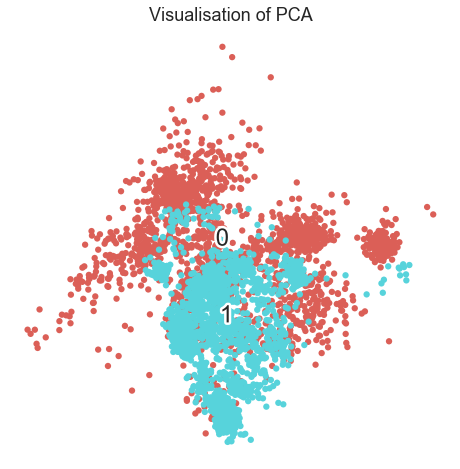

In [33]:
x_subset = X_train[0:20000]
y_subset = y_train[0:20000]

from sklearn.decomposition import PCA

time_start = time.time()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(x_subset)


pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4','pca5'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]
pca_df['pca5'] = pca_result[:,4]

top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
ecg_scatter(top_two_comp.values,y_subset) # Visualizing the PCA output


**t-SNE**

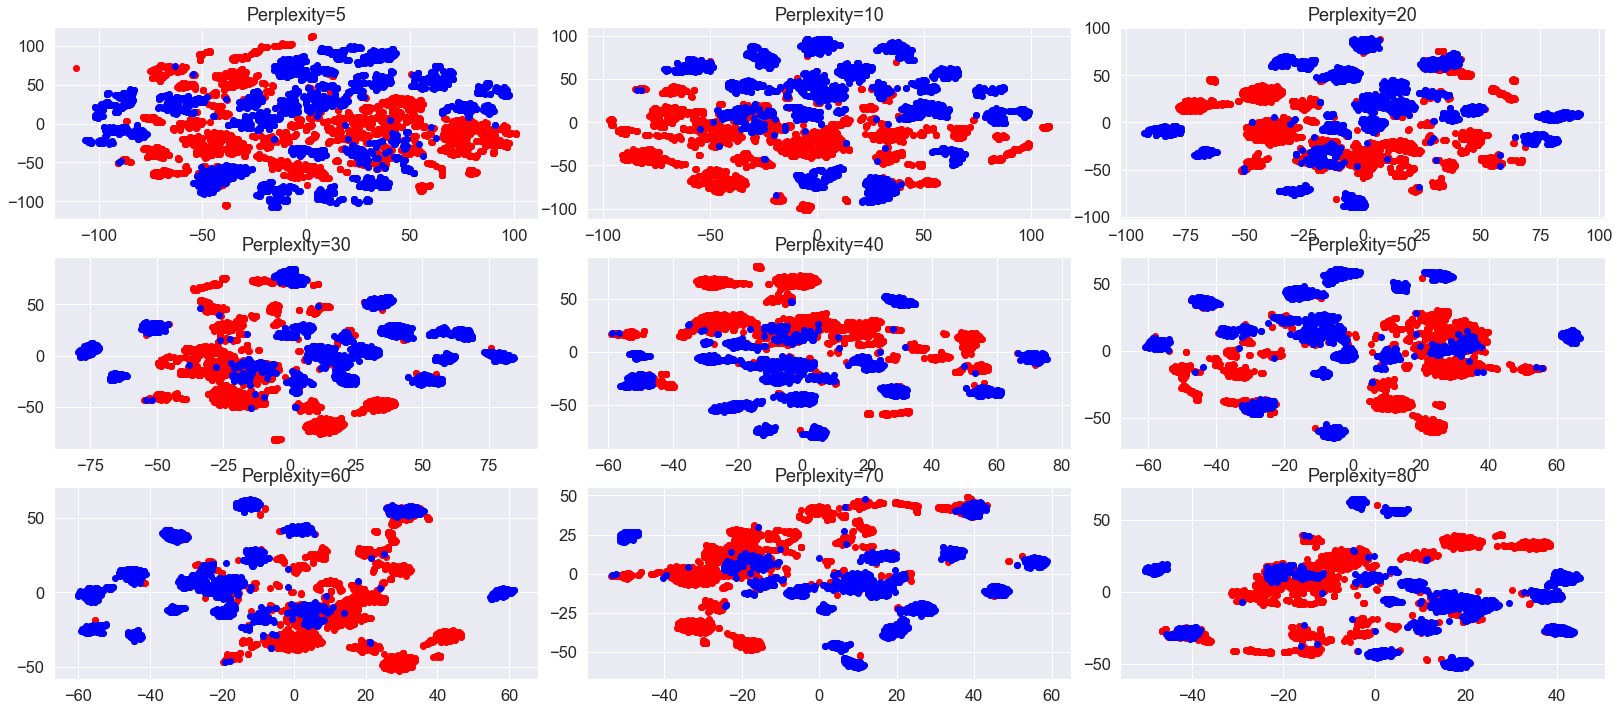

In [41]:
(fig, subplots) = plt.subplots(3, 3, figsize=(24, 12))
fig.subplots_adjust(left=0.0625, right=0.96, wspace=0.1)
perplexities = [5, 10, 20, 30, 40, 50, 60, 70, 80]

# testing perplexity values for visualisation results
for i, perplexity in enumerate(perplexities):
    ax = subplots[i//3][i%3]
    Y = TSNE(n_components=2, perplexity= perplexity).fit_transform(X_test)
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[np.where(y_test==0), 0], Y[np.where(y_test==0), 1], c="r")
    ax.scatter(Y[np.where(y_test==1), 0], Y[np.where(y_test==1), 1], c="b")
    ax.axis('tight')
   
plt.show()

**K-means**

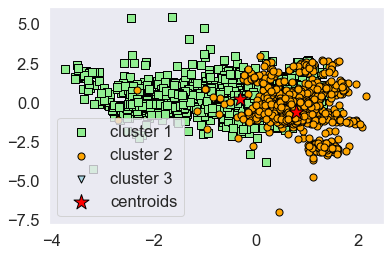

[1 0 0 ... 1 0 0]


In [37]:

km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X_train)
# plot the 3 clusters

plt.scatter(
    X_train[y_km == 0, 0], X_train[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X_train[y_km == 1, 0], X_train[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X_train[y_km == 2, 0], X_train[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()


print(km.labels_)

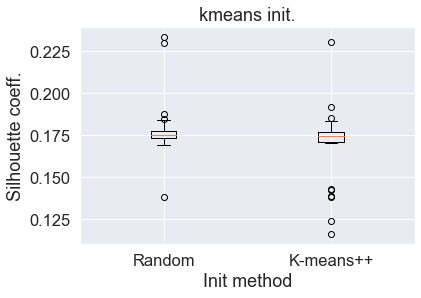

In [38]:
np.random.seed(11)
tt=40 # try 40 runs for each initialization method
sclist=[]
k=3
sscores=np.zeros((tt))
for t in range(tt):
    kmeans = KMeans(init='random', n_clusters=k, n_init=1).fit(X_train)
    labels=kmeans.labels_
    sscores[t]=metrics.silhouette_score(X_train, labels, sample_size=3000, metric='euclidean')
sclist.append(sscores)

sscores=np.zeros((tt))
for t in range(tt):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=1).fit(X_train)
    labels=kmeans.labels_
    sscores[t]=metrics.silhouette_score(X_train, labels, sample_size=3000, metric='euclidean')
sclist.append(sscores)

plt.boxplot(sclist, labels=['Random','K-means++'])
plt.xlabel('Init method')
plt.ylabel('Silhouette coeff.')
plt.title('kmeans init.');

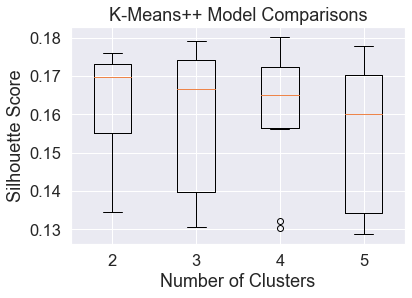

In [39]:

n_clus = [2,3,4,5]
sil_scr=[]

for i in range(10):
    for clust in n_clus:
        kmeans = KMeans(init='k-means++', n_clusters=clust).fit(X_train)
        sil_scr=np.append(sil_scr, metrics.silhouette_score(X_train, kmeans.labels_, sample_size=3000, metric='euclidean'))
plt.boxplot([sil_scr[0:11],sil_scr[11:21],sil_scr[21:31],sil_scr[31:41]], labels=['2','3','4','5'])
plt.xlabel('Number of Clusters')
plt.title('K-Means++ Model Comparisons')
plt.ylabel('Silhouette Score')
plt.show()


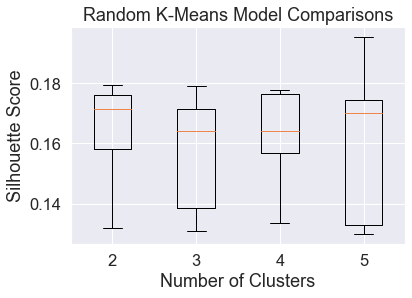

In [40]:

n_clus = [2,3,4,5]
sil_scr=[]

for i in range(10):
    for clust in n_clus:
        kmeans = KMeans(init='random', n_clusters=clust).fit(X_train)
        sil_scr=np.append(sil_scr, metrics.silhouette_score(X_train, kmeans.labels_, sample_size=3000, metric='euclidean'))
plt.boxplot([sil_scr[0:11],sil_scr[11:21],sil_scr[21:31],sil_scr[31:41]], labels=['2','3','4','5'])
plt.xlabel('Number of Clusters')
plt.title('Random K-Means Model Comparisons')
plt.ylabel('Silhouette Score')
plt.show()

**Exploring Important Predictors**

Text(0, 0.5, 'Feature Importance')

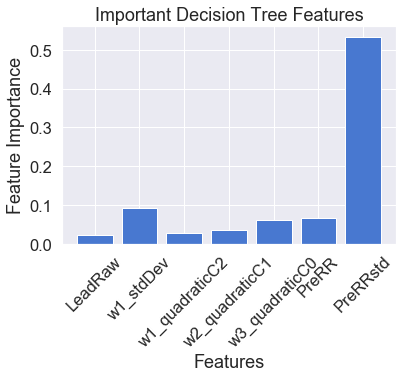

In [94]:
# creating decision tree using optimsed values found below

dt_model = DecisionTreeClassifier(max_depth=9)
dt_model.fit(X_train, y_train)
dt_imp = dt_model.feature_importances_

plt.bar([x for x in range(len(dt_imp[np.where(dt_imp>0.021)]))], dt_imp[np.where(dt_imp>0.021)])
positions = [0,1,2,3,4,5,6]
labels = list( X_cols[i] for i in [1,27,35,56,77,83,86])
plt.xticks(positions, labels, rotation=45)
plt.title('Important Decision Tree Features')
plt.xlabel('Features')
plt.ylabel('Feature Importance')

## Section 4: Analysis

Various classification techniques will be implemented. Each model will be run 30 times.


**Decision Tree**

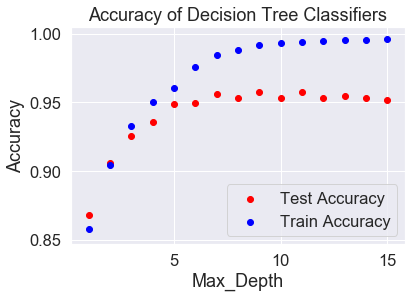

In [42]:
# determining the optimal value for max_depth

scores=np.zeros((3,15))
for i in range(15):
    # creating classifier
    dt_clf = DecisionTreeClassifier(max_depth=i+1) 
    dt_clf.fit(X_train, y_train)
    test_pred = cross_val_predict(dt_clf, X_test, y_test, cv=10)
    #train_pred = cross_val_predict(dt_clf, X_train, y_train, cv=10)
    # recording accuracy score for classifier
    scores[0,i] = i+1
    scores[1,i] = metrics.accuracy_score(y_test, test_pred)
    scores[2,i] = dt_clf.score(X_train, y_train)
    
# plotting scores 

plt.scatter(scores[0,:], scores[1,:], label='Test Accuracy', color='red')
plt.scatter(scores[0,:], scores[2,:], label='Train Accuracy', color='blue')
plt.xlabel('Max_Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy of Decision Tree Classifiers')
plt.legend()
plt.show()

**Adaboost - Decision Tree**

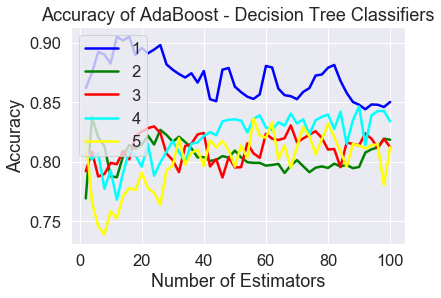

In [43]:
# determining the optimal value for max_depth and n_estimators/2
max_runs = 50
max_dep = 5

cols = ['blue','green','red','cyan','yellow']


for j in range(max_dep):
    scores=np.zeros((2,max_runs))
    for i in range(max_runs):
        ab_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=j+1),n_estimators=(i+1)*2)
        ab_model.fit(X_train, y_train)
        scores[:,i] = [(i+1)*2, ab_model.score(X_test, y_test)]
        
    plt.plot(scores[0,:], scores[1,:], label=j+1, color=cols[j])
    
# plotting scores 

plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy of AdaBoost - Decision Tree Classifiers')
plt.legend()
plt.show()

**Random Forest**

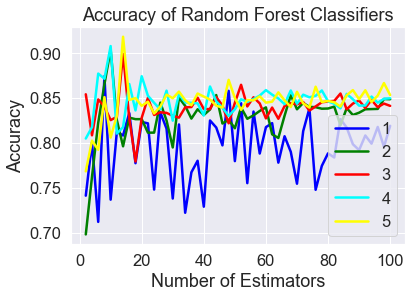

In [44]:
# determining the optimal value for max_depth and n_estimators
max_runs = 50
max_dep = 5

cols = ['blue','green','red','cyan','yellow']

for j in range(max_dep):
    scores=np.zeros((2,max_runs))
    for i in range(max_runs):
        rf_model = RandomForestClassifier(n_estimators=(i+1)*2,max_depth=j+1)
        rf_model.fit(X_train, y_train)
        scores[:,i] = [(i+1)*2, rf_model.score(X_test, y_test)]
        
    plt.plot(scores[0,:], scores[1,:], label=j+1, color=cols[j])
    
# plotting scores 

plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy of Random Forest Classifiers')
plt.legend()
plt.show()

**Adaboost - Random Forest**

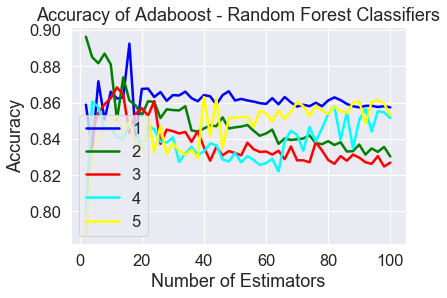

In [45]:
# determining the optimal value for max_depth and n_estimators/2
max_runs = 50
max_dep = 5

cols = ['blue','green','red','cyan','yellow']


for j in range(max_dep):
    scores=np.zeros((2,max_runs))
    for i in range(max_runs):
        ab_model = AdaBoostClassifier(RandomForestClassifier(n_estimators=(i+1)*2,max_depth=j+1),n_estimators=(i+1)*2)
        ab_model.fit(X_train, y_train)
        scores[:,i] = [(i+1)*2, ab_model.score(X_test, y_test)]
        
    plt.plot(scores[0,:], scores[1,:], label=j+1, color=cols[j])
    
# plotting scores 

plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy of Adaboost - Random Forest Classifiers')
plt.legend()
plt.show()

**Logistic Regression**

In [19]:
##printing the model evaluaters
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8410918324164198
Precision: 0.8239549839228296
Recall: 0.8675412611087601


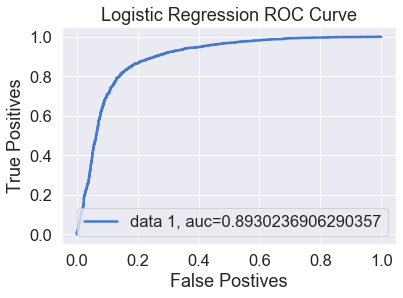

In [63]:
## ROC Curve 
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False Postives')
plt.ylabel('True Positives')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc=4)
plt.show()

**SVC**

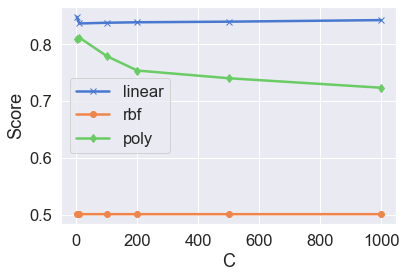

In [22]:
from sklearn import svm
score_svc=[]
score_rbf=[]
score_poly=[]

cvals=[1.0, 10.0, 100.0, 200.0, 500.0, 1000.0]
for c in cvals:  # SVM regularization parameter
    svc = svm.SVC(kernel='linear', C=c, gamma='scale').fit(X_train, y_train)
    rbf_svc = svm.SVC(kernel='rbf', gamma=0.8, C=c).fit(X_train, y_train)
    poly_svc = svm.SVC(kernel='poly', degree= 3, C=c, gamma='scale').fit(X_train, y_train)

    # check on performance
    score_svc.append(svc.score(X_test,y_test))
    score_rbf.append(rbf_svc.score(X_test,y_test))
    score_poly.append(poly_svc.score(X_test,y_test))

plt.plot(cvals,score_svc,'x-',label='linear')
plt.plot(cvals,score_rbf,'o-',label='rbf')  
plt.plot(cvals,score_poly,'d-',label='poly')
plt.xlabel('C')
plt.ylabel('Score')
plt.legend(loc='best');

**Adaboost svc**

In [ ]:
# DO NOT RUN
# Code requires a lot of time to execute. See the report for the output

cols = ['blue','green','red','cyan','yellow']
max_runs = 50
max_dep = 5
cvals=[1.0, 10.0, 100.0, 200.0, 500.0, 1000.0]
#svc=SVC(probability=True, kernel='linear')
for j in range(max_dep):
    scores=np.zeros((2,max_runs))
    for i in range(max_runs):
        ab_model = AdaBoostClassifier(base_estimator=svm.SVC(kernel='linear', C=cvals[j], gamma='scale', probability=True), n_estimators=(i+1)*2, learning_rate=1 )
        model = ab_model.fit(X_train, y_train)
        #y_pred = model.predict(X_test) 
        scores[:,i] = [(i+1)*2, model.score(X_test, y_test)]
    plt.plot(scores[0,:], scores[1,:], label=j+1, color=cols[j])

# plotting scores ÷........................./.lp[]

plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy of SVC')
plt.legend()
plt.show()

## Section 4: Evaluation

The performance of the classification techniques implemented above will be evaluated.

In [79]:
repeats = 30

# To store the true and false positive results for each model over the number of "repeats"
# TPR = _re[0,:], FPR = _re[1,:]

dt_scr = np.zeros(repeats)
rf_scr = np.zeros(repeats)
ab_scr = np.zeros(repeats)
abrf_scr = np.zeros(repeats)
lr_scr = np.zeros(repeats)
absvc_scr = np.zeros(2)
svm_scr = np.zeros(repeats)

In [51]:
# creating function to plot confusion matricies

def plot_cm(y_pred, y, model):
    cf_matrix = confusion_matrix(y, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.title('{} Confusion Matrix'.format(model))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

**Descion Tree**

In [82]:
# optimal value found in Section 3

opt_md = 9

# creating the optimal decision tree model

for i in range(30):
    dt_clf = DecisionTreeClassifier(max_depth=opt_md) 
    dt_clf.fit(X_train, y_train)
    y_pred = cross_val_predict(dt_clf, X_test, y_test, cv=10)
    dt_scr[i] = metrics.accuracy_score(y_test, y_pred)
    

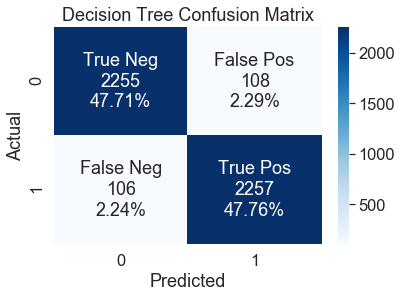

In [53]:
# plotting confusion matrix
plot_cm(cross_val_predict(dt_clf, X_test, y_test, cv=10), y_test, 'Decision Tree')

**Random Forest**

In [83]:
# optimal value found in Section 3

opt_md = 3
opt_nest = 20

# creating the optimal decision tree model

for i in range(30):
    rf_model = RandomForestClassifier(n_estimators=opt_nest,max_depth=opt_md)
    rf_model.fit(X_train, y_train)
    y_pred = cross_val_predict(rf_model, X_test, y_test, cv=10)
    rf_scr[i] = metrics.accuracy_score(y_test, y_pred)
    

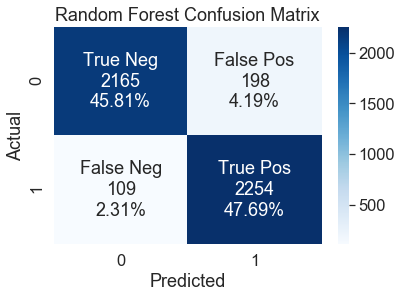

In [55]:
# plotting confusion matrix
plot_cm(cross_val_predict(rf_model, X_test, y_test, cv=10), y_test, 'Random Forest')

**Adaboost - Decision Tree**

In [84]:
# optimal value found in Section 3

opt_md = 3
opt_nest = 20

# creating the optimal decision tree model

for i in range(30):
    ab_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=opt_md), n_estimators=opt_nest)
    ab_model.fit(X_train, y_train)
    y_pred = cross_val_predict(ab_model, X_test, y_test, cv=10)
    ab_scr[i] = metrics.accuracy_score(y_test, y_pred)
    

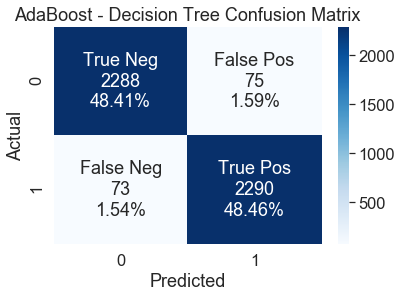

In [57]:
# plotting confusion matrix
plot_cm(cross_val_predict(ab_model, X_test, y_test, cv=10), y_test, 'AdaBoost - Decision Tree')

**Adaboost - Random Forest**

In [85]:
# optimal value found in Section 3

opt_md = 1
opt_nest = 9

# creating the optimal decision tree model

for i in range(30):
    abrf_model = AdaBoostClassifier(RandomForestClassifier(n_estimators=20, max_depth=opt_md), n_estimators=opt_nest)
    abrf_model.fit(X_train, y_train)
    y_pred = cross_val_predict(abrf_model, X_test, y_test, cv=10)
    abrf_scr[i] = metrics.accuracy_score(y_test, y_pred)
    

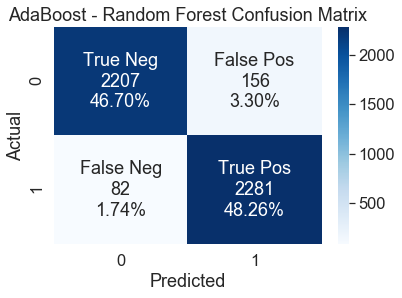

In [59]:
# plotting confusion matrix
plot_cm(cross_val_predict(abrf_model, X_test, y_test, cv=10), y_test, 'AdaBoost - Random Forest')

**Logistic Regression**

In [86]:
# creating the optimal decision tree model

for i in range(30):
    lr_model = LogisticRegression(max_iter=200)
    lr_model.fit(X_train, y_train)
    y_pred = cross_val_predict(lr_model, X_test, y_test, cv=10)
    lr_scr[i] = metrics.accuracy_score(y_test, y_pred)
    

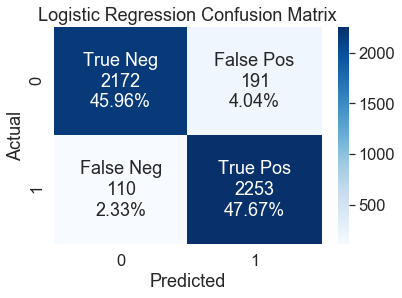

In [67]:
# plotting confusion matrix
plot_cm(cross_val_predict(lr_model, X_test, y_test, cv=10), y_test, 'Logistic Regression')

**SVM**

In [87]:
# creating the optimal decision tree model

for i in range(30):
    svc = svm.SVC(kernel='linear', C=1, gamma='scale').fit(X_train, y_train)
    svm_scr[i] = svc.score(X_test,y_test)
    

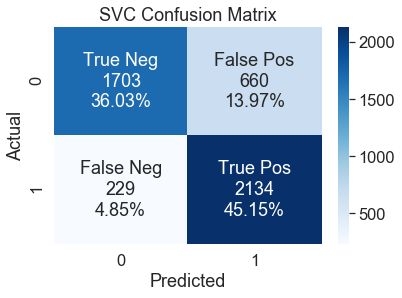

In [73]:
# plotting confusion matrix
plot_cm(svc.predict(X_test), y_test, 'SVC')

**AdaBoost - SVM**

In [80]:
# running twice due to runtime issues
# optimal value found in Section 3

c=3
opt_nest = 5

# creating the optimal decision tree model

for i in range(2):
    absvc_model = AdaBoostClassifier(base_estimator=svm.SVC(kernel='linear', C=c, gamma='scale', probability=True), n_estimators=opt_nest, learning_rate=1 )
    absvc_model.fit(X_train, y_train)
    y_pred = cross_val_predict(absvc_model, X_test, y_test, cv=10)
    absvc_scr[i] = metrics.accuracy_score(y_test, y_pred)
    

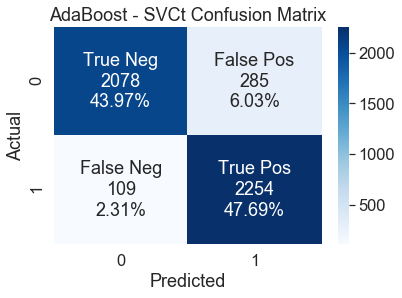

In [81]:
# plotting confusion matrix
plot_cm(cross_val_predict(absvc_model, X_test, y_test, cv=10), y_test, 'AdaBoost - SVCt')

## Section 5: Comparison

The performance of the algorithms will be compared.

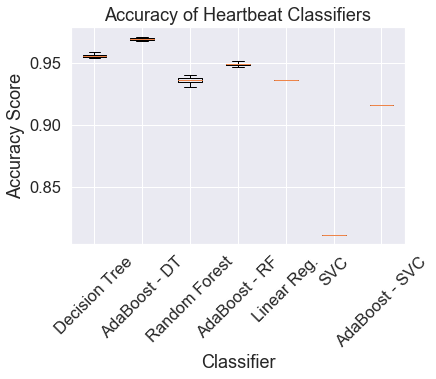

In [97]:
# script for box plot or roc curve of performance of all classifiers
plt.boxplot([dt_scr, ab_scr, rf_scr,abrf_scr,lr_scr, svm_scr, absvc_scr], labels=['Decision Tree', 'AdaBoost - DT', 'Random Forest', 'AdaBoost - RF', 'Linear Reg.', 'SVC', 'AdaBoost - SVC'])
plt.xlabel('Classifier')
plt.ylabel('Accuracy Score')
plt.title('Accuracy of Heartbeat Classifiers')
plt.xticks(rotation=45)
plt.show()

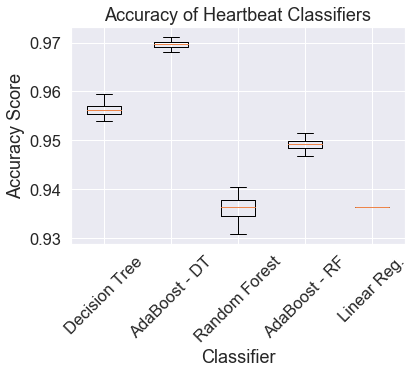

In [96]:
# script for box plot or roc curve of performance of all classifiers
plt.boxplot([dt_scr, ab_scr, rf_scr,abrf_scr,lr_scr], labels=['Decision Tree', 'AdaBoost - DT', 'Random Forest', 'AdaBoost - RF', 'Linear Reg.',])
plt.xlabel('Classifier')
plt.ylabel('Accuracy Score')
plt.title('Accuracy of Heartbeat Classifiers')
plt.xticks(rotation=45)
plt.show()